# X2K Kinase Database Enrichment Analyses

**:: Previous Analyses ::**
- Lists of differentially expressed genes from GEO kinase perturbation experiments (genetic or small molecule perturbations) were iteratively run through the Expression2Kinases (X2K) pipeline to predict the kinases regulating that system.
- For each experiment, the perturbed kinase is known and can therefore be compared against the ranked predicted kinase list as a measure of X2K's performance. When predicted kinases that are the true target kinase (matched) are more highly ranked ("highest" rank = 0) that run of X2K receives a better fitness score.     


**:: Objectives ::**
1. Determine whether there's variation in quality amongst the different KEA kinase databases. Quality is defined in terms of predicted kinase accuracy across many GEO kinase perturbation experiments with known.
2. Within a given database, identify cluster modules that appear when plotting heatmaps of Target Kinases (the kinase perturbed in each experiment) vs. Predicted Kinases (the kinases returned by KEA).
3. For each cluster module, determine whether the gene list of combined Predicted and Target Kinases is enriched for any ontology terms (using the Enrichr API).

In [23]:
print('Created by Brian Schilder (created 7/23/18\n')
import sys
print(sys.version)


Created by Brian Schilder (created 7/23/18

3.6.5 (v3.6.5:f59c0932b4, Mar 28 2018, 03:03:55) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]


In [24]:
% cd Kinase_Enrichment_Comparisons


[Errno 2] No such file or directory: 'Kinase_Enrichment_Comparisons'
/Users/schilder/Desktop/X2K_Web/Kinase_Enrichment_Comparisons


## 0. Preprocessing

### Convert Databases to HGNC

In [25]:
import pandas as pd

# Standardize genes to HGNC symbols
mapping = pd.read_table('../../X2K_Summaries/General_Resources/Moshe_mapping/mappingFile_2017.txt', header=None)
greekLetters = pd.read_csv('../../X2K_Summaries/General_Resources/GreekLetter_Converter.csv', names=['Greek', 'Abbrev'], header=0 )
greekLetters = greekLetters.apply(lambda x: x.str.strip('\xa0'))

def standardizeGeneSymbol(gene):
    if gene.__contains__('AURORA'):
        HGNC = 'AURK' + gene[-1]
    elif any(substring in gene for substring in greekLetters['Greek']):
        for letter in greekLetters['Greek']:
            LETTER = letter.upper()
            if gene.__contains__(LETTER):
                HGNC = gene.replace(LETTER, greekLetters.loc[greekLetters['Greek']==letter,'Abbrev'].values[0] )
    else:
        HGNC = gene
    if HGNC in mapping[0]:
        HGNC = mapping.iloc[mapping[0]==HGNC, 1]
    return HGNC

# Get list of all kinases in KEA2018
import pandas as pd
KEA2018 = pd.read_csv('../../X2k_Databases/KINASE/KEA_2018/KEA2018_KINASES.csv', header=None)#pd.read_csv("KEA/UberKeaFile.csv")
KEA2018.head()
allKinases = KEA2018.iloc[:,2].unique().tolist()

### Import Results and Convert to Pvalue Matrices

In [26]:
import pandas as pd
import pickle
x2kResults_eachKinaseDB_UP = pickle.load( open( "x2kResults_syns_eachKinaseDB_DN.pkl", "rb" ) )
x2kResults_eachKinaseDB_DN = pickle.load( open( "x2kResults_syns_eachKinaseDB_DN.pkl", "rb" ) )

 
def pvalue_matrix(dataType, results):
    nameKey = {'ChEA':'simpleName','KEA':'name'}
    ## dict_keys(['X2K', 'ChEA', 'KEA', 'G2N', 'input', 'Experiment', 'x2k_options', 'binaryString'])
    # DB -> Experiment -> Kinase -> kinase results
    pvalDict={}
    for i,expt in enumerate(results):
        KEAres = results[expt][dataType]
        exptName = results[expt]['Experiment']
        predictedKinases = [y[nameKey[dataType]] for y in KEAres]
        predictedPvals = [y['pvalue'] for y in KEAres]
        pvalDict[exptName] = dict(zip(predictedKinases, predictedPvals))
    resultsDF = pd.DataFrame(pvalDict) 
    return resultsDF

def all_matrices(x2k_kinase_db_results):
    matrixDict={}
    for db in x2k_kinase_db_results.keys():
        print("Processing matrix for: " + db)
        matrixDict[db] = pvalue_matrix(dataType='KEA', results=x2k_kinase_db_results[db])
    return matrixDict

x2k_matrixDict_UP = all_matrices(x2kResults_eachKinaseDB_UP)
del x2kResults_eachKinaseDB_UP
x2k_matrixDict_DN = all_matrices(x2kResults_eachKinaseDB_DN)
del x2kResults_eachKinaseDB_DN

Processing matrix for: kea 2018
Processing matrix for: ARCHS4
Processing matrix for: iPTMnet
Processing matrix for: NetworkIN
Processing matrix for: Phospho.ELM
Processing matrix for: Phosphopoint
Processing matrix for: PhosphoPlus
Processing matrix for: MINT
Processing matrix for: kea 2018


Processing matrix for: ARCHS4
Processing matrix for: iPTMnet
Processing matrix for: NetworkIN
Processing matrix for: Phospho.ELM
Processing matrix for: Phosphopoint
Processing matrix for: PhosphoPlus
Processing matrix for: MINT


### Fill in NAs

In [27]:
import pandas as pd
import numpy as np

def add_absent_perturbed(DF):
    perturbed = DF.columns.str.split("_").str[0]
    predicted = DF.index.tolist()
    absent = list(set(perturbed) - set(predicted))
    emptyDF = pd.DataFrame(1.0, index= absent, columns=DF.columns)
    newDF = pd.concat([DF, emptyDF], axis=0)
    return newDF

def import_fillNA_addMissingKinases(DF, fillNAs=True, addAbsentKinases=True, negLogPval=True):  
    if fillNAs==True:
        DF.fillna(1.0, inplace=True)
    if addAbsentKinases==True:
        DF = add_absent_perturbed(DF)
    if negLogPval==True:
        DF  = np.negative(np.log(DF))
    return DF      
        
# Import and correct data at the same time
def preprocess_pvalMatrices(matrixDict):
    matrixDict_filled={}
    for db in matrixDict:
        DF = matrixDict[db].copy()
        matrixDict_filled[db] = import_fillNA_addMissingKinases(DF)
    return matrixDict_filled


x2k_matrixDict_negLog_UP = preprocess_pvalMatrices(x2k_matrixDict_UP)
x2k_matrixDict_negLog_DN = preprocess_pvalMatrices(x2k_matrixDict_DN)

### Convert Values to Ranks 

In [28]:
def values_to_ranks(DF, ascending=False):
    Ranks={}
    # assign ranks based on given value (could be pvalue, -log(pvalue), ranks, etc)
    for col in DF:
        # Since zscore comes from -log(pvalue), flip the rank order so that low numbered ranks are still the best
        orderedCol = DF[col].sort_values(ascending=ascending)
        # Shuffle order of 0s
        nonZeros = orderedCol.loc[orderedCol!=0]
        try:
            zeros = orderedCol.loc[orderedCol==0].sample(frac=1)
        except:
            zeros = pd.Series(dtype=float)
        shuffledCol = pd.concat([nonZeros, zeros])
        # Assign ranks
        newRanks = pd.Series(data=range(0,len(shuffledCol)), name=col, index=shuffledCol.index)
        newRanks.sort_index(inplace=True) # Sort by index
        Ranks[col] = dict(zip(newRanks.index, newRanks.values))
    return pd.DataFrame(Ranks)
    
def values_to_ranks_over_kinaseDBs(matrixDict_filled, ascending):
    matrixDict_ranks={}
    for db in matrixDict_filled:
        print(db)
        DF = matrixDict_filled[db]
        matrixDict_ranks[db] = values_to_ranks(DF, ascending)
    return matrixDict_ranks

# When getting ranks directly 
x2k_matrixDict_ranks_UP = values_to_ranks_over_kinaseDBs(x2k_matrixDict_negLog_UP, ascending=False)
x2k_matrixDict_ranks_DN = values_to_ranks_over_kinaseDBs(x2k_matrixDict_negLog_DN, ascending=False)

kea 2018


ARCHS4


iPTMnet


NetworkIN


Phospho.ELM
Phosphopoint


PhosphoPlus


MINT


kea 2018


ARCHS4


iPTMnet


NetworkIN


Phospho.ELM
Phosphopoint


PhosphoPlus


MINT


### Values to Zscores to Ranks

In [29]:
from scipy import stats

def values_to_zscores(DF, dropZeros=True):
    if dropZeros==True:
        # Drop all rows that ONLY have (0). Never appeared across any experiment
        # Keeping the all 0s messes up the zscore
        df = DF[(DF.T != 0).any()]
    else:
        df = DF.copy()
    zscoreDF = pd.DataFrame(stats.zscore(df, axis=1), columns=df.columns, index=df.index)
    return zscoreDF

def values_to_zscores_to_Ranks_over_kinaseDBs(matrixDict_filled):
    matrixDict_zscoreRanks={}
    for db in matrixDict_filled:
        print(db)
        DF = matrixDict_filled[db]
        zscoreDF = values_to_zscores(DF)
        matrixDict_zscoreRanks[db] = values_to_ranks(zscoreDF)
    return matrixDict_zscoreRanks
        
x2k_matrixDict_zscoreRanks_UP = values_to_zscores_to_Ranks_over_kinaseDBs(x2k_matrixDict_negLog_UP)
x2k_matrixDict_zscoreRanks_DN = values_to_zscores_to_Ranks_over_kinaseDBs(x2k_matrixDict_negLog_DN)

kea 2018


ARCHS4


iPTMnet


NetworkIN


Phospho.ELM


Phosphopoint


PhosphoPlus


MINT


kea 2018


ARCHS4


iPTMnet


NetworkIN


Phospho.ELM


Phosphopoint


PhosphoPlus


MINT


## 1. Assess Quality of Kinase Databases

### KDE Plots: For Each Kinase Database

Plotting KDE for : X2K_UP_pvalue_ranks - KDE Distributions


Plotting KDE for : X2K_DN_pvalue_ranks - KDE Distributions


Plotting KDE for : X2K_UP_pvalueZscore_ranks - KDE Distributions


Plotting KDE for : X2K_DN_pvalueZscore_ranks - KDE Distributions


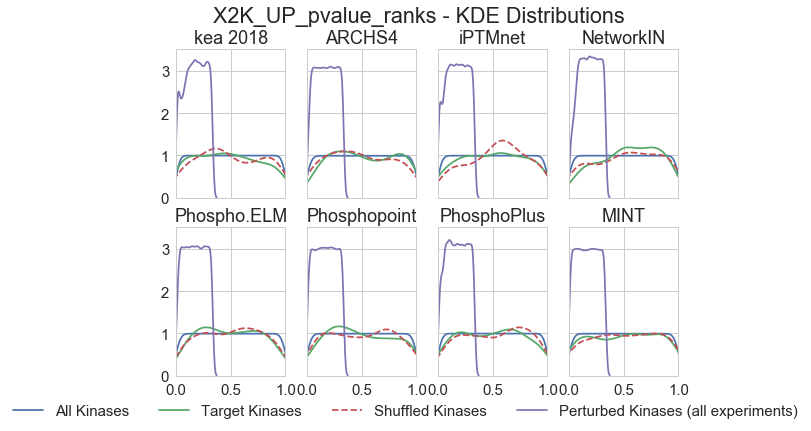

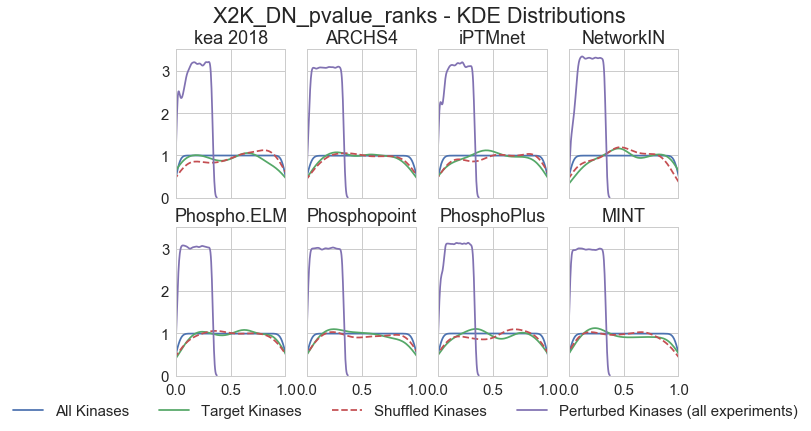

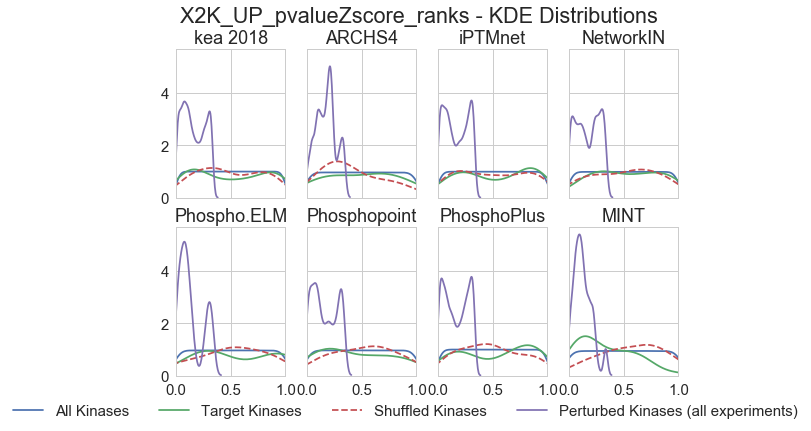

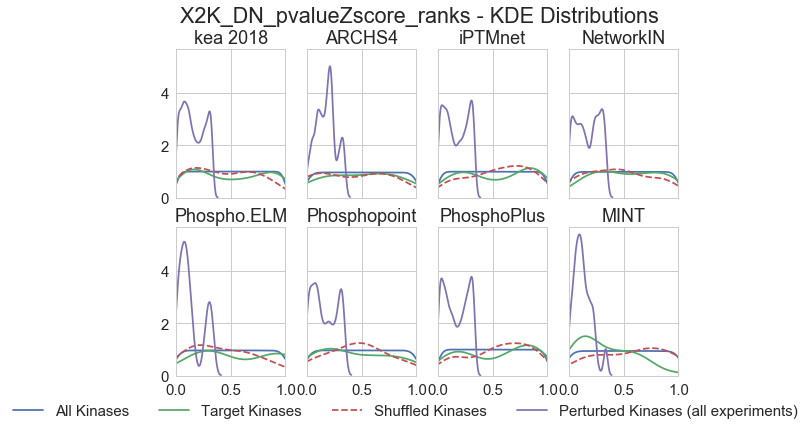

In [30]:
import seaborn as sn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') 

sn.set(font_scale=1.5)
sn.set_style("whitegrid")



def scaled_ranks(DFstack):
    scaledDF = DFstack.copy()
    # Rescale ranks from 0-1
    scaledDF['Rank'] -= scaledDF['Rank'].min() 
    scaledDF['Rank'] /= scaledDF['Rank'].max()
    return scaledDF

def KDE_subplots(x2k_matrixDict_ranks, scaledRanks=True, saveFig=False, supTitle=''):
    f, AX = plt.subplots(2, int(len(x2k_matrixDict_ranks)/2), sharex='all', sharey='all', figsize=(9, 6))
    AX = AX.ravel()
    print('Plotting KDE for : '+supTitle)
    for i,db in enumerate(x2k_matrixDict_ranks):
        ax=AX[i]
        DF = x2k_matrixDict_ranks[db]
        n = len(DF)
        DFstack = DF.stack().reset_index()
        DFstack.columns = ['Kinase','Experiment','Rank']
        if scaledRanks==True:
            DFstack = scaled_ranks(DFstack)
        
        # print("line 0...")
        # Null distribution (all kinase ranks)
        g0 = sn.distplot( DFstack['Rank'], label='All Kinases',rug=False, hist=False, norm_hist=True, ax=ax).set_xlim(0,1)
        
        # print("line 1...")
        # Target Kinases Only
        DFstack_target = DFstack.loc[DFstack['Kinase']==DFstack['Experiment'].str.split('_').str[0]]
        g1 = sn.distplot( DFstack_target['Rank'], label='Target Kinases',rug=False, hist=False, norm_hist=True, ax=ax).set_xlim(0,1)
       
        # print("line 2...")
        # Shuffled targets
        DFstack_shuffled = DFstack_target.copy()
        DFstack_shuffled.loc[:,['Experiment','Rank']] = DFstack.sample(n=len(DFstack_target)).loc[:,['Experiment','Rank']].values
        g2 = sn.distplot( DFstack_shuffled['Rank'], label='Shuffled Kinases',rug=False, hist=False, norm_hist=True, ax=ax,\
                      kde_kws={"linestyle":"--"}).set_xlim(0,1)
         
        # print("line 3...")
        # Perturbed kinases (regardless of experiment)
        perturbedKinases = set(DFstack['Experiment'].str.split('_').str[0])
        DFstack_perturbed = DFstack[DFstack['Kinase'].isin(perturbedKinases)] 
        DFstack_perturbed['Rank']  /= len(DFstack.columns) # Correct for additional samples
        g3 = sn.distplot( DFstack_perturbed['Rank'], label='Perturbed Kinases (all experiments)',rug=False, hist=False, norm_hist=True, ax=ax)
        g3.legend(bbox_to_anchor=(-1.5, -0.15), loc='upper center', borderaxespad=0., ncol=4)
        g3.set_xlim(0,1)
        #g3.set_title(db + "(n="+str(n)+")")
        g3.set_title(db)
        g3.set_xlabel('')
        
        if i<len(x2k_matrixDict_ranks)-1:
            ax.legend_.remove() 
        plt.suptitle(supTitle)
    if saveFig==True:
        plt.draw()
        f.savefig('Figures/Rank_Distribution_Plots/'+ supTitle+'.png')
    return f
 

fig1 = KDE_subplots(x2k_matrixDict_ranks_UP, scaledRanks=True, saveFig=True, supTitle='X2K_UP_pvalue_ranks - KDE Distributions') 
fig2 = KDE_subplots(x2k_matrixDict_ranks_DN, scaledRanks=True, saveFig=True, supTitle='X2K_DN_pvalue_ranks - KDE Distributions')

fig3 = KDE_subplots(x2k_matrixDict_zscoreRanks_UP, scaledRanks=True, saveFig=True, supTitle='X2K_UP_pvalueZscore_ranks - KDE Distributions') 
fig4 = KDE_subplots(x2k_matrixDict_zscoreRanks_DN, scaledRanks=True, saveFig=True, supTitle='X2K_DN_pvalueZscore_ranks - KDE Distributions')


# x2k_matrixDict_ranks_UP['kea 2018'].mean(axis=1).sort_values()
# x2k_matrixDict_ranks_UP['kea 2018'].std(axis=1).sort_values()

## 2. Identify Cluster Modules

### Clustermaps for Each Kinase Database
(only 'KEA 2018' shown to save space)

X2K_Pvalue_Ranks_UP


X2K_PvalueZscore_Ranks_UP


X2K_Pvalue_Ranks_DN


X2K_PvalueZscore_Ranks_DN


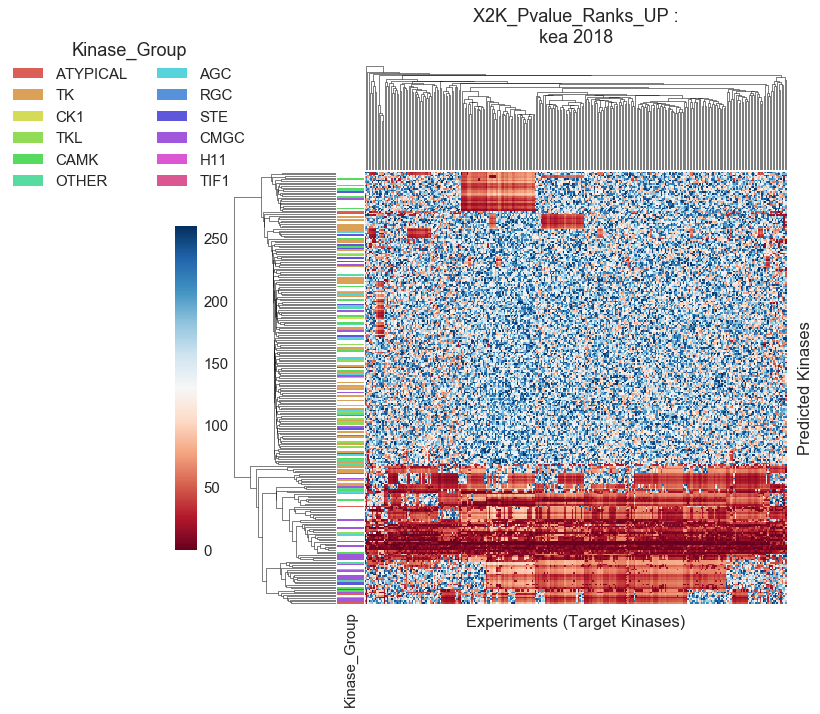

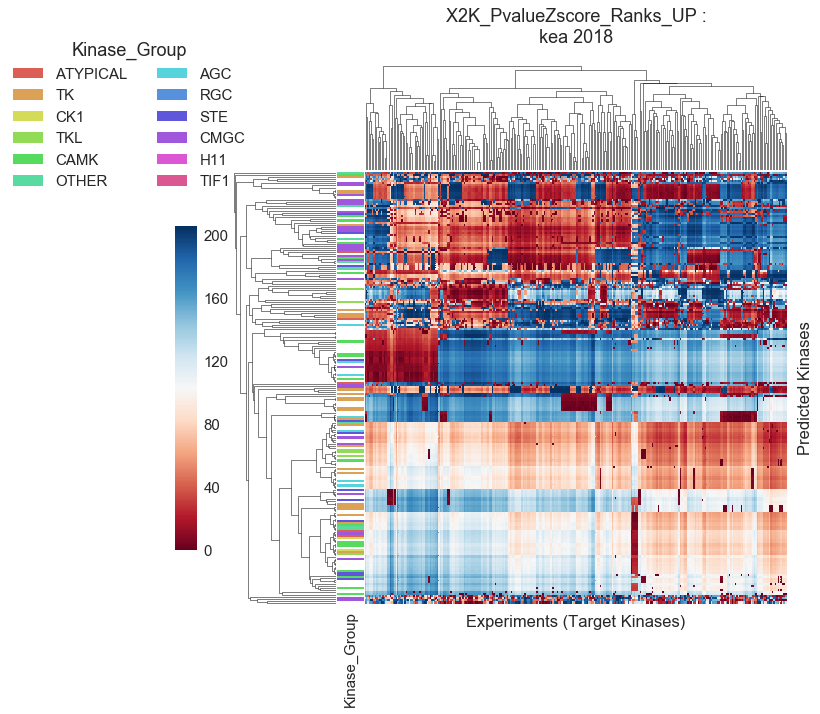

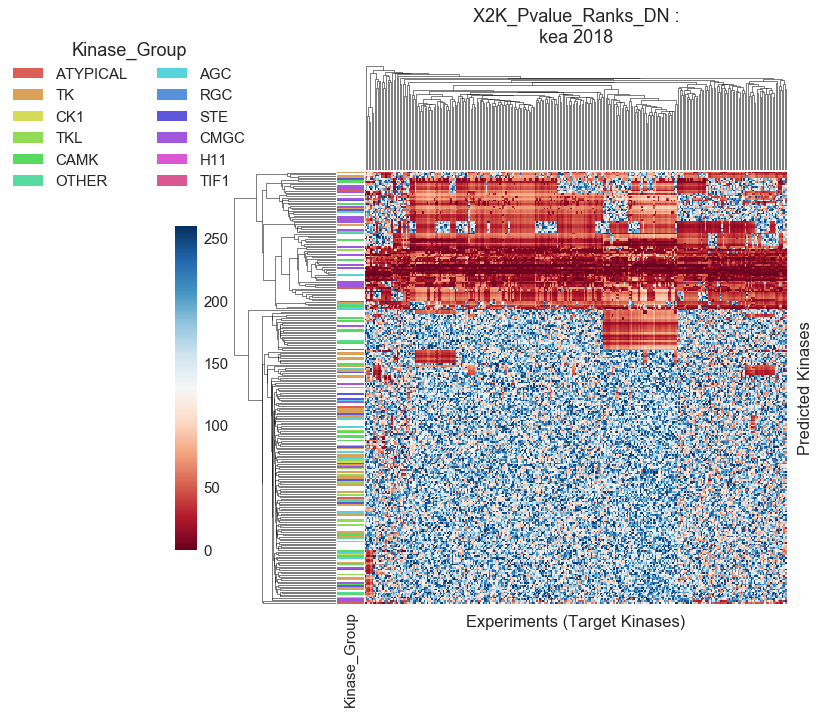

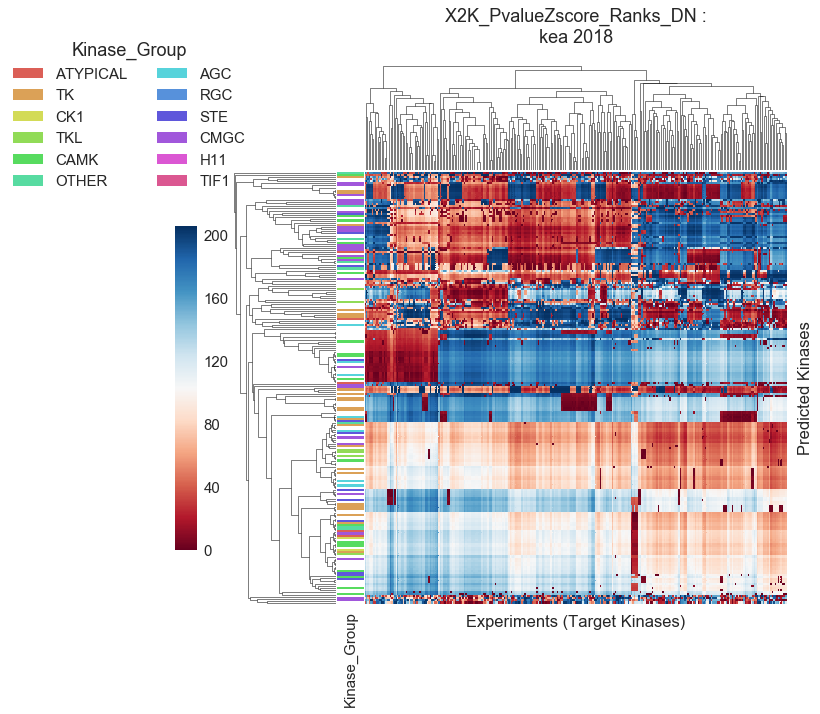

In [31]:
# Color heatmap by kinase groups/families
def get_kinase_groups_families():
    homo = pd.read_excel('../../X2K_Summaries/General_Resources/Kinase.com/Kinome_Hsap_updated.xls').loc[:,['Name','Group','Family','Subfamily']]
    mus = pd.read_excel('../../X2K_Summaries/General_Resources/Kinase.com/Kinome_Mmus.xls').loc[:,['Gene Name','Group','Family','Subfamily']]
    mus = mus.rename(columns={'Gene Name':'Name'})
    # Fill missing Subfamily info with Family
    ##homo['Subfamily'] = homo['Subfamily'].fillna(homo['Family'])
    ##mus['Subfamily'] = mus['Subfamily'].fillna(mus['Family'])
    
    # Capitalize everything
    homo = homo.apply(lambda x: x.astype(str).str.upper())
    mus = mus.apply(lambda x: x.astype(str).str.upper())
    both = pd.concat([homo, mus]).drop_duplicates()
    both['Subfamily'] = both['Subfamily'].fillna('[No Info.]')
    both.columns = ['Kinase','Kinase_Group','Kinase_Family','Kinase_Subfamily']
    both.index = both['Kinase']
    return both
    
def category_colors_dict(category):
    KEA_gf = get_kinase_groups_families()
    uniqueCats = KEA_gf[category].unique()
    colorCodes = sn.color_palette("hls", len(uniqueCats))
    colorDict = dict(zip(uniqueCats, colorCodes))
    row_colors = KEA_gf[category].map(colorDict)
    return row_colors, colorDict

def plotClustermap(DF, plotTitle='', z_score=None, category='Kinase_Group', saveFig=True):
    #DF.dropna(inplace=True)
    # Clustermap
    row_colors, colorDict = category_colors_dict(category)
    g = sn.clustermap(DF, z_score=z_score, row_colors=row_colors, cmap="RdBu") #"inferno", "hot"
    ## Change labels
    g.ax_heatmap.set_title(plotTitle, pad=130)
    g.ax_heatmap.set_xticklabels('')
    g.ax_heatmap.set_yticklabels('')
    g.ax_heatmap.set_xlabel('Experiments (Target Kinases)')
    g.ax_heatmap.set_ylabel('Predicted Kinases')
    ## Set position of main colorbar
    g.cax.set_position([.05, .2, .03, .45]) 
    ## Draw legend for classes
    for label in colorDict.keys():
        g.ax_row_dendrogram.bar(0, 0, color=colorDict[label], label=label, linewidth=0)
    g.ax_row_dendrogram.legend(loc="upper right", ncol=2, bbox_to_anchor=(.35, 1.35), borderaxespad=1).set_title(category)
    if saveFig==True:
        g.savefig('Figures/Clustermaps/'+plotTitle+'_clustermap.png')


def iterate_clustermaps(matrixDict, method , z_score=None, category='Kinase_Family', saveFig=False):
    print(method)
    for db in matrixDict:
        if db == 'kea 2018': #****** TEMPORARY LIMITER TO SAVE SPACE*******#
            DF =  matrixDict[db] 
            plotClustermap(DF=DF, plotTitle=method+" :\n"+db, z_score=z_score, category=category, saveFig=saveFig)
        
# Plot/save Clustermap
## UP
iterate_clustermaps(x2k_matrixDict_ranks_UP, method="X2K_Pvalue_Ranks_UP", z_score=None, category='Kinase_Group', saveFig=False)
iterate_clustermaps(x2k_matrixDict_zscoreRanks_UP, method="X2K_PvalueZscore_Ranks_UP", z_score=None, category='Kinase_Group', saveFig=False)
 
## DN
iterate_clustermaps(x2k_matrixDict_ranks_DN, method="X2K_Pvalue_Ranks_DN", z_score=None, category='Kinase_Group', saveFig=False)
iterate_clustermaps(x2k_matrixDict_zscoreRanks_DN, method="X2K_PvalueZscore_Ranks_DN", z_score=None, category='Kinase_Group', saveFig=False)
 

### Identify Non-Specific Kinases
(Threshold Method: Kinases that have an high average rank across experiments (all-red x-axis clusters))  

Text(0.5,0.98,'% of Predicted Kinases that were non-specific')

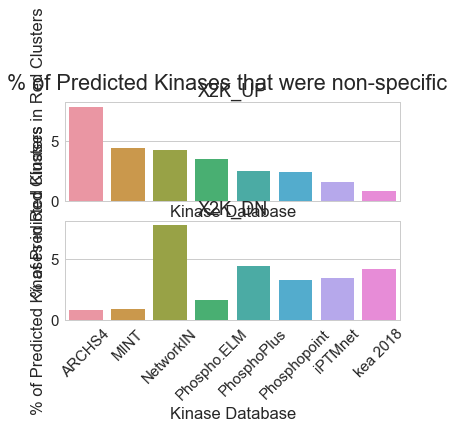

In [32]:
def get_red_cluster(nLog_ranks, method, threshold=50, save=True):
   # get row/kinase average rank
    meanRanks = nLog_ranks.mean(axis=1)
    topKinases = list(meanRanks[meanRanks<threshold].sort_values().index)
    # Subet DF to just top ranked kinases
    topKinases_DF = nLog_ranks[nLog_ranks.index.isin(topKinases)]
    if save==True:
        topKinases_DF.to_csv('Results/Red_Clusters/'+method+"_redCluster.csv", index=False )
    return topKinases_DF


def get_red_cluster_for_each_kinaseDB(matrixDict_ranks, method, threshold=100):
    redClusters={}
    percentage_report={}
    for db in matrixDict_ranks:
        DF = matrixDict_ranks[db]
        redClust = get_red_cluster(DF, method, threshold)
        redClusters[db] = redClust
        percentage_report[db] = len(redClust)/len(DF)*100
    return redClusters, percentage_report
 
def plot_redCluster_report(percentage_report, title, ax, sort=True):
    yvar = '% of Predicted Kinases in Red Clusters'
    barDF = pd.Series(percentage_report).reset_index()
    barDF.columns = ['Kinase Database',yvar]
    if sort==True:
        barDF = barDF.sort_values(by=yvar,ascending=False)
    sns.barplot(data=barDF, x='Kinase Database', y=yvar, ax=ax).set_title(title)
    


import matplotlib.pyplot as plt
import seaborn as sns
# X2K 
X2K_UP_redClusters, perReport_X2K_UP = get_red_cluster_for_each_kinaseDB(x2k_matrixDict_ranks_UP,'X2K_UP_nLogPval_ranks', 25)
X2K_DN_redClusters, perReport_X2K_DN = get_red_cluster_for_each_kinaseDB(x2k_matrixDict_ranks_DN, 'X2K_DN_nLogPval_ranks', 25)

f, ax = plt.subplots(2, 1, sharex=True)
plt.xticks(rotation=45)
plot_redCluster_report(perReport_X2K_UP, title="X2K_UP", ax=ax[0], sort=True)
plt.xticks(rotation=45)
plot_redCluster_report(perReport_X2K_DN, title="X2K_DN", ax=ax[1], sort=False)
f.suptitle('% of Predicted Kinases that were non-specific')

### Identify Kinases in Cluster Modules 
(Heatmap clusters after applying z-score)  

In [33]:
import seaborn as sn
import matplotlib.pyplot as plt

# x2k_matrixDict_ranks_UP
# x2k_matrixDict_zscoreRanks_UP
# x2k_matrixDict_ranks_DN
# x2k_matrixDict_zscoreRanks_DN

X = x2k_matrixDict_zscoreRanks_UP['kea 2018'].copy()
X.shape
sum( X.apply(lambda x: sum(x.isnull())) ) 

0

### Correlation Matrix: Clustermap w/ Hierarchical Clustering
Unlike the other heatmaps, this shows the correlation

Text(0.5,0.98,'Clustermap:\nPredicted Kinase Rank Correlations\n [kea 2018]')

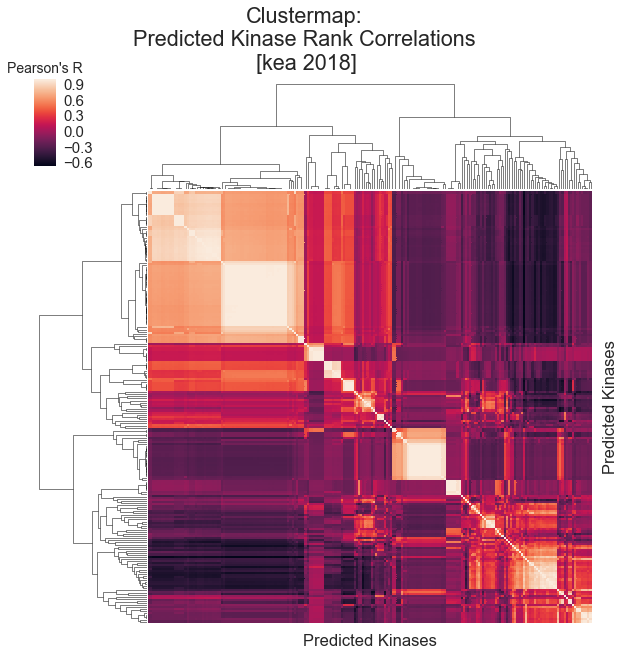

In [34]:
corrMatrix = X.T.corr() # Default method = pearson  
# corrMatrix_diag = np.triu(np.ones(corrMatrix.shape)).astype(np.bool).__invert__()

g = sn.clustermap(data=corrMatrix)
g.ax_heatmap.set_xticklabels('')
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_xlabel('Predicted Kinases')
g.ax_heatmap.set_ylabel('Predicted Kinases')
plt.title("Pearson's R", fontsize=14)

plt.suptitle('Clustermap:\nPredicted Kinase Rank Correlations\n [kea 2018]')

### Dimensionality Reduction

#### PCA

Stored variables and their in-db values:


Text(0.5,1,'PCA of Columns')

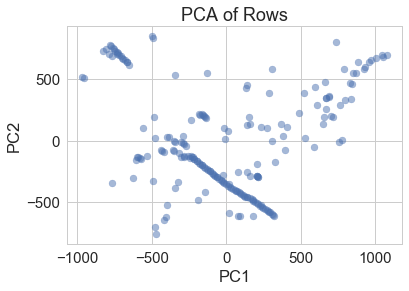

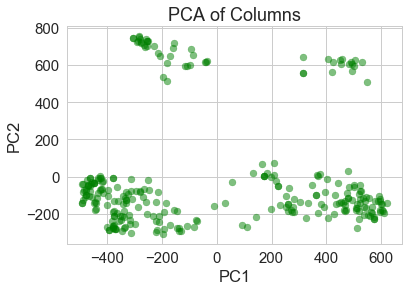

In [35]:
% store

from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # project from 64 to 2 dimensions
pca_rows = pca.fit_transform(X)
plt.subplots()
plt.scatter(pca_rows[:,0], pca_rows[:,1], alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Rows')
# inverseX = pca.inverse_transform(pca_projected)
# plt.scatter(inverseX[:,0], inverseX[:,1], alpha=0.5)
# plt.xlabel('PC1')
# plt.ylabel('PC2')

pca = PCA(n_components=2)  # project from 64 to 2 dimensions
pca_cols = pca.fit_transform(X.T)
plt.subplots()
plt.scatter(pca_cols[:,0], pca_cols[:,1], alpha=0.5, color='green')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Columns')

#### t-SNE

Stored variables and their in-db values:


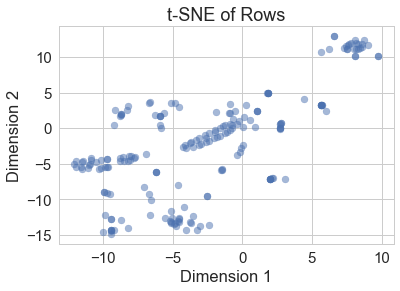

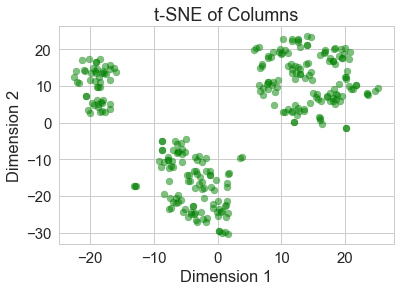

In [36]:
% store

from sklearn.manifold import TSNE
import numpy as np
np.random.seed(42)

# Rows
tsne_results_rows = TSNE(verbose=False).fit(X)
tsne_rows = tsne_results_rows.fit_transform(X)
plt.subplots()
plt.title('t-SNE of Rows')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.scatter(x=tsne_rows[:,0], y=tsne_rows[:,1], alpha=0.5)

# Cols
tsne_results_cols = TSNE( verbose=False).fit(X.T) #metric="correlation",
tsne_cols = tsne_results_cols.fit_transform(X.T) 
plt.subplots()
plt.title('t-SNE of Columns')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.scatter(x=tsne_cols[:,0], y=tsne_cols[:,1], alpha=0.5, color='green')

### Optimized K-means Clustering

- To identify discerete red clusters in heatmap, need to do K-means twice: once on the kinases, and once on the experiments.
- K-means requires the user to specify the number of clusters, which has the potential to introduce bias. Instead, I optimized the number of clusters by iteratively measuring the gap-statistic and estimated number of clusters.

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
 
def optimalK(X, nrefs=3, maxClusters=15): 
    # Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    # Params:
    #     data: ndarry of shape (n_samples, n_features)
    #     nrefs: number of sample reference datasets to create
    #     maxClusters: Maximum number of clusters to test for
    # Returns: (gaps, optimalK)
    gaps = np.zeros((len(range(1, maxClusters+1)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters+1)):
        # print("Testing "+str(k)+" clusters....")
        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            # Create new random reference set
            randomReference = np.random.random_sample(size=X.shape)
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            refDisp = km.inertia_
            refDisps[i] = refDisp
        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(X)
        origDisp = km.inertia_
        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

def iterate_optimalK(X):
    # get optimal K for raw data
    n, gapdf = optimalK(X, nrefs=3, maxClusters=15)
    # print('Optimal K for raw data is: ', n)
    # create KMeans given optimal n and fit
    km = KMeans(n_clusters=n)
    kmFit = km.fit(X)
    # Find optimal clusters for cluster centers from above
    n, gapdf = optimalK(km.cluster_centers_, nrefs=3, maxClusters=len(km.cluster_centers_))
    print('Optimal K for first clusters is: ', n)
    return n, km, kmFit
 
 

def kMeans_and_plot(X, method='', database='', plot=False):
    print('Conducting Optimized K-means Clustering : '+method+' - '+database)
    nClusts, k_means, kmFit = iterate_optimalK(X)
    y_kmeans = k_means.predict(X)
    X_transform = k_means.transform(X)
    ## Plot
    if plot==True:
        plt.figure()
        plt.scatter(X[:,0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
        centers = k_means.cluster_centers_
        plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.title('K-means Clustering ('+method+')\nClusters: '+ str(nClusts) +' , Database: '+database)
    return {'nClusts':nClusts, 'k_means':k_means, 'kmFit':kmFit, 'X_transform':X_transform, 'y_kmeans':y_kmeans}

# Kmeans directly on z-scored ranks
rawRanks_kinases = kMeans_and_plot(X.as_matrix(), method='Z-scored Ranks', database='KEA 2018 Ranks', plot=False)
rawRanks_expts = kMeans_and_plot(X.T.as_matrix(), method='Z-scored Ranks', database='KEA 2018 Ranks', plot=False)
# Kmeans on correlation matrix
corr_kinases = kMeans_and_plot(corrMatrix.as_matrix(), method='Correlation Matrix', database='KEA 2018 Ranks')
corr_expts = kMeans_and_plot(corrMatrix.T.as_matrix(), method='Correlation Matrix', database='KEA 2018 Ranks')

"""
# Kmeans on PCA results
PCA_kinases = kMeans_and_plot(pca_rows, method='PCA', database='KEA 2018 Ranks')
PCA_expts = kMeans_and_plot(pca_cols, method='PCA', database='KEA 2018 Ranks')

# Kmeans on tSNE results
TSNE_kinases = kMeans_and_plot(tsne_rows, method='t-SNE', database='KEA 2018 Ranks')
TSNE_expts = kMeans_and_plot(tsne_cols, method='t-SNE', database='KEA 2018 Ranks')
"""





Conducting Optimized K-means Clustering : Z-scored Ranks - KEA 2018 Ranks


Optimal K for first clusters is:  15
Conducting Optimized K-means Clustering : Z-scored Ranks - KEA 2018 Ranks


Optimal K for first clusters is:  15
Conducting Optimized K-means Clustering : Correlation Matrix - KEA 2018 Ranks


Optimal K for first clusters is:  15
Conducting Optimized K-means Clustering : Correlation Matrix - KEA 2018 Ranks


Optimal K for first clusters is:  15


"\n# Kmeans on PCA results\nPCA_kinases = kMeans_and_plot(pca_rows, method='PCA', database='KEA 2018 Ranks')\nPCA_expts = kMeans_and_plot(pca_cols, method='PCA', database='KEA 2018 Ranks')\n\n# Kmeans on tSNE results\nTSNE_kinases = kMeans_and_plot(tsne_rows, method='t-SNE', database='KEA 2018 Ranks')\nTSNE_expts = kMeans_and_plot(tsne_cols, method='t-SNE', database='KEA 2018 Ranks')\n"

### Clustermap with K-means Clusters


"\nplotClustermap(X, PCA_kinases, PCA_expts, plotTitle='Clustermap & K-means Clusters:\nPCA; KEA 2018', z_score=None, saveFig=False)\nplotClustermap(X, TSNE_kinases, TSNE_expts, plotTitle='Clustermap & K-means Clusters:\nt-SNE; KEA 2018', z_score=None, saveFig=False)\n"

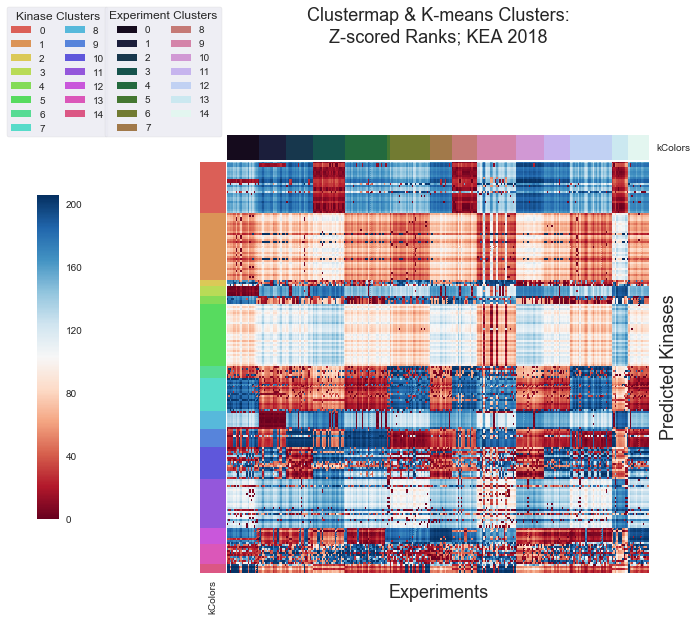

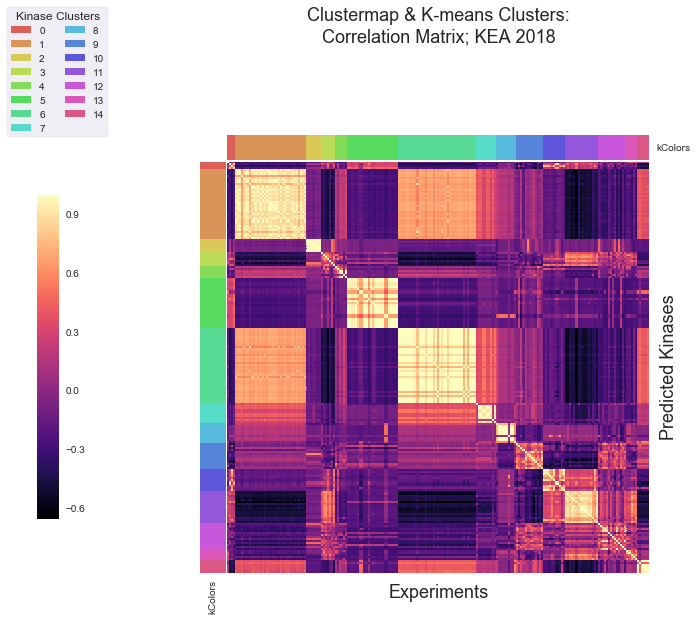

In [38]:
sn.set(font_scale=1)

def plotClustermap(X, kMeans_rows, kMeans_cols, plotTitle, z_score=None, saveFig=False, mirroredAxes=False, cmap='RdBu'):
    x = X.copy()
    xT = x.copy().T
    # Get row colors
    colors = sn.color_palette("hls", kMeans_rows['nClusts']) #cubehelix
    rowColorDict = dict(zip( range(0, kMeans_rows['nClusts']), colors))
    rowColors = [rowColorDict[y] for y in kMeans_rows['y_kmeans']]
    x['kCluster'] = kMeans_rows['y_kmeans']
    x['kColors'] = rowColors
    x.sort_values(by='kCluster', inplace=True)
    rowColors = x['kColors']
    xport = x 
    
    # Get col colors
    colors = sn.color_palette("cubehelix", kMeans_cols['nClusts']) #cubehelix
    colColorDict = dict(zip( range(0, kMeans_cols['nClusts']), colors))
    colColors = [colColorDict[y] for y in  kMeans_cols['y_kmeans']]
    xT['kCluster'] = kMeans_cols['y_kmeans']
    xT['kColors'] = colColors
    xT.sort_values(by='kCluster', inplace=True)
    xTport = xT
    # Sort cols in original df
    x = x.reindex(xT.index, axis=1) 
    
    if mirroredAxes==False:
        col_colors=xT['kColors']
    else:
        col_colors=rowColors
    g = sn.clustermap(x, row_colors=rowColors, col_colors=col_colors, cmap=cmap, 
                      z_score=z_score, row_cluster=False, col_cluster=False) #"inferno", "hot"
    ## Change label
    g.ax_heatmap.set_title(plotTitle, pad=120, fontsize=18)
    g.ax_heatmap.set_xticklabels('')
    g.ax_heatmap.set_yticklabels('')
    g.ax_heatmap.set_xlabel('Experiments',  fontsize=18)
    g.ax_heatmap.set_ylabel('Predicted Kinases',  fontsize=18)
    ## Set position of main colorbar
    g.cax.set_position([.05, .2, .03, .45])
    # Row legend
    for label in rowColorDict.keys():
        g.ax_row_dendrogram.bar(0, 0, color=rowColorDict[label], label=label, linewidth=0)
    g.ax_row_dendrogram.legend(loc="upper right", ncol=2, bbox_to_anchor=(.25, 1.4), borderaxespad=1, frameon=True).set_title('Kinase Clusters')
    if mirroredAxes==False:
        for label in colColorDict.keys():
            g.ax_col_dendrogram.bar(0, 0, color=colColorDict[label], label=label, linewidth=0)
        g.ax_col_dendrogram.legend(loc="upper right", ncol=2, bbox_to_anchor=(.01, 1.31), borderaxespad=1,  frameon=True).set_title('Experiment Clusters')
    if saveFig==True:
        g.savefig('Figures/Clustermaps/'+plotTitle+'_clustermap.png')
    return {'kmeansDF':xport, 'kmeansDF_transposed':xTport}
        

# Raw Ranks
rawRanks_kmeansResults = plotClustermap(X, rawRanks_kinases, rawRanks_expts, plotTitle='Clustermap & K-means Clusters:\nZ-scored Ranks; KEA 2018',
                               z_score=None, saveFig=False)
# Correlation Matrix
corr_kmeansResults = plotClustermap(corrMatrix, corr_kinases, corr_kinases, plotTitle='Clustermap & K-means Clusters:\nCorrelation Matrix; KEA 2018', 
               z_score=None, saveFig=False, mirroredAxes=True, cmap='magma')

"""
plotClustermap(X, PCA_kinases, PCA_expts, plotTitle='Clustermap & K-means Clusters:\nPCA; KEA 2018', z_score=None, saveFig=False)
plotClustermap(X, TSNE_kinases, TSNE_expts, plotTitle='Clustermap & K-means Clusters:\nt-SNE; KEA 2018', z_score=None, saveFig=False)
"""

### Extract Kinases From Each Cluster Module
- A cluster module is defined as the genes within the intersect between a k-means cluster on the x-axis (e.g. Target/perturbed kinases) and a k-means cluster y-axis (Predicted Kinases).
- For example, in a 15 cluster x 14 cluster heatmap, there would be (15*14) 210 cluster modules.
- A clusterID identifies each cluster by: (row_cluster_number, col_cluster_number)

In [39]:
def create_clusterDict(kmeansResults):
    xport = kmeansResults['kmeansDF']
    xTport = kmeansResults['kmeansDF_transposed']
    clusterDict={}
    # Loop through row clusts
    for rowClust in xport['kCluster'].unique():
        print("Processing rowCluster : "+str(rowClust))
        sub = xport[xport['kCluster']==rowClust]
        # Loop through col clusts
        for colClust in xTport['kCluster'].unique():
            cols = xTport.loc[xTport['kCluster']==colClust].index.tolist()
            csub = sub.loc[:,sub.columns.isin(cols)] 
            clusterDict[tuple([rowClust, colClust])] = {'predictedKinases':csub.index.tolist(),
                                  'targetKinases': csub.columns.str.split("_").str[0].tolist() } 
    return clusterDict

rawRanks_clustDict  = create_clusterDict(rawRanks_kmeansResults)
corr_clustDict  = create_clusterDict(corr_kmeansResults)

Processing rowCluster : 0
Processing rowCluster : 1
Processing rowCluster : 2
Processing rowCluster : 3
Processing rowCluster : 4
Processing rowCluster : 5
Processing rowCluster : 6
Processing rowCluster : 7
Processing rowCluster : 8


Processing rowCluster : 9
Processing rowCluster : 10
Processing rowCluster : 11
Processing rowCluster : 12
Processing rowCluster : 13
Processing rowCluster : 14
Processing rowCluster : 0
Processing rowCluster : 1
Processing rowCluster : 2
Processing rowCluster : 3


Processing rowCluster : 4
Processing rowCluster : 5
Processing rowCluster : 6
Processing rowCluster : 7
Processing rowCluster : 8
Processing rowCluster : 9
Processing rowCluster : 10
Processing rowCluster : 11
Processing rowCluster : 12
Processing rowCluster : 13


Processing rowCluster : 14


## 3. Test Cluster Module Enrichment w/ Enrichr API

In [40]:
import jupyter_nbextensions_configurator


In [41]:
 

import json
import requests

## Analyze gene list
def enrichr_submitQuery(geneList, description):
    ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/addList'
    genes_str = '\n'.join(geneList)
    payload = {
        'list': (None, genes_str),
        'description': (None, description)
    }
    response = requests.post(ENRICHR_URL, files=payload)
    if not response.ok:
        raise Exception('Error analyzing gene list')
    ID_info = json.loads(response.text)
    # print(ID_info)
    return ID_info

## View added gene list
def enrichr_viewGeneList(ID_info):
    ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/view?userListId=%s'
    user_list_id = ID_info['userListId']#363320
    response = requests.get(ENRICHR_URL % user_list_id)
    if not response.ok:
        raise Exception('Error getting gene list')
    gene_list = json.loads(response.text)
    # print(gene_list)
    return gene_list

## Get enrichment results
def enrichr_enrichmentResults(ID_info, gene_set_library = 'KEGG_2015'):
    ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/enrich'
    query_string = '?userListId=%s&backgroundType=%s'
    user_list_id = ID_info['userListId']#363320 
    response = requests.get(
        ENRICHR_URL + query_string % (user_list_id, gene_set_library)
     )
    if not response.ok:
        raise Exception('Error fetching enrichment results')
    results = json.loads(response.text)
    # print(results)
    return results

## Find terms that contain a given gene
def enrichr_findGeneTerms(gene):
    ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/genemap'
    query_string = '?json=true&setup=true&gene=%s'
    gene = gene#'AKT1'
    response = requests.get(ENRICHR_URL + query_string % gene)
    if not response.ok:
        raise Exception('Error searching for terms') 
    gene_search = json.loads(response.text)
    print(gene_search)
    return gene_search

## Download file of enrichment results
def enrichr_downloadResults(ID_info):
    ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/export'
    query_string = '?userListId=%s&filename=%s&backgroundType=%s'
    user_list_id = ID_info['userListId']#363320
    filename = 'example_enrichment'
    gene_set_library = 'KEGG_2015'
    url = ENRICHR_URL + query_string % (user_list_id, filename, gene_set_library)
    response = requests.get(url, stream=True)
    with open(filename + '.txt', 'wb') as f:
        for chunk in response.iter_content(chunk_size=1024): 
            if chunk:
                f.write(chunk)

# Run Enrichr for each cluster
def run_Enrichr(clusterDict):
    enrichrResults={}
    for clustID in clusterDict: 
        # print("Processing : "+ str(clustID))
        cluster = clusterDict[clustID]
        geneList = cluster['predictedKinases']+cluster['targetKinases']
        ID_info = enrichr_submitQuery(geneList=geneList, description=str(clustID) )
        results='Fail'
        while results=='Fail':
            try:
                results = enrichr_enrichmentResults(ID_info=ID_info, gene_set_library = 'KEGG_2015')
                enrichrResults[clustID] = {'results':results,'geneList':geneList}
            except:
                results = 'Fail' 
    # Get the top terms for each cluster
    names=['Rank', 'Term name', 'P-value', 'Z-score', 'Combined score', 'Overlapping genes', 'Adjusted p-value', 'Old p-value',
           'Old adjusted p-value']
    enrichrDF = pd.DataFrame([enrichrResults[x]['results']['KEGG_2015'][0] for x in enrichrResults], columns=names, index=None)
    enrichrDF['geneList length'] = [len(enrichrResults[x]['geneList']) for x in enrichrResults]
    enrichrDF['Library'] = 'KEGG_2015'
    enrichrDF['clusterID'] = enrichrResults.keys() 
    return enrichrDF

# Raw Ranks
rawRanks_enrichrDF = run_Enrichr(rawRanks_clustDict)
rawRanks_enrichrDF.sort_values(by='geneList length',ascending=False, inplace=True) 

# Correlation Matrix
# corr_enrichrDF = run_Enrichr(corr_clustDict)









225

In [44]:
rawRanks_enrichrSig = rawRanks_enrichrDF[rawRanks_enrichrDF['Adjusted p-value']<=0.05]
print(str(round(len(rawRanks_enrichrSig)/len(rawRanks_enrichrDF)*100, 2)) + \
      "% of the clusters are significantly enriched for ontological terms.")
rawRanks_enrichrSig.head()

100.0% of the clusters are significantly enriched for ontological terms.


,Rank,Term name,P-value,Z-score,Combined score,Overlapping genes,Adjusted p-value,Old p-value,Old adjusted p-value,geneList length,Library,clusterID
19,1,pancreatic cancer,2.253000e-11,-2.043397,50.096283,"[MAP2K1, PIK3CA, CDK4, AKT1, BRAF, TGFBR1, JAK...",1.036380e-09,1.132983e-07,5.211723e-06,62,KEGG_2015,"(1, 4)"
27,1,adherens junction,5.873888e-13,-1.857313,52.307667,"[YES1, SRC, ERBB2, NLK, MET, EGFR, TGFBR1, FGF...",2.643250e-11,2.531101e-08,1.138995e-06,62,KEGG_2015,"(1, 12)"
21,1,erbb signaling pathway,7.865808e-11,-2.047170,47.629276,"[MAP2K4, CAMK2D, ERBB3, SRC, ERBB2, ABL1, AKT1...",3.460955e-09,5.797205e-07,2.550770e-05,61,KEGG_2015,"(1, 6)"
24,1,erbb signaling pathway,2.288295e-14,-2.047170,64.298303,"[CAMK2D, MAP2K1, ERBB3, PIK3CA, ERBB2, ABL1, A...",1.098382e-12,4.341485e-09,2.083913e-07,60,KEGG_2015,"(1, 9)"
87,1,focal adhesion,5.859550e-11,-2.178540,51.327197,"[FLT1, SRC, ERBB2, ILK, RAF1, MET, EGFR, PTK2,...",2.578202e-09,3.413598e-07,1.501983e-05,59,KEGG_2015,"(5, 12)"
